MAD Statistics

In [8]:
import os 
from scipy.io import loadmat
import Actigraph_Metrics
import numpy as np
from scipy import stats
import math
import itertools 
import neurokit2 as nk
import matplotlib.pyplot as plt
import pandas as pd

# Place MAD data into SBS groups
# data_dir = '/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data'
data_dir = r'C:\Users\sidha\OneDrive\Sid_stuff\PROJECTS\PedAccel\data_analysis\Vitals_accel_analysis\PatientData'

window_size = 100 # 100 is 1 second worth of time

lead_time = 15
slice_size_min = 16

Tag = "Retro"

min = 5

**Use SICKBAY Retrospective data to compute metric**

C:\Users\sidha\OneDrive\Sid_stuff\PROJECTS\PedAccel\data_analysis\Vitals_accel_analysis\PatientData\Patient11
Processing patient: Patient11
dict_keys(['__header__', '__version__', '__globals__', 'x_mag', 'heart_rate', 'SpO2', 'respiratory_rate', 'blood_pressure_systolic', 'blood_pressure_mean', 'blood_pressure_diastolic', 'sbs', 'start_time', 'PRNs', 'Default'])


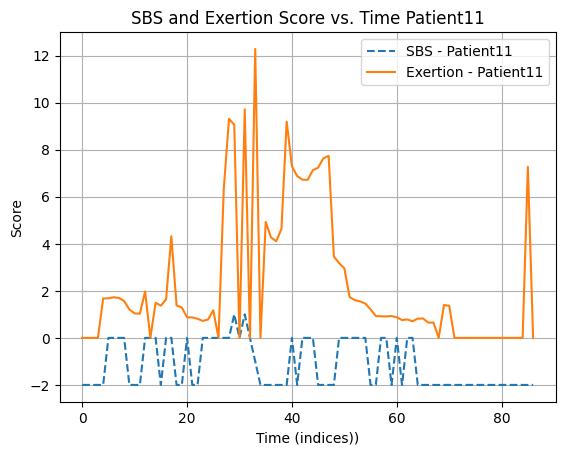

Patient11 SBS Score : -2, Median Exertion Score: 8.19e-01
Patient11 SBS Score : 0, Median Exertion Score: 1.57e+00
Patient11 SBS Score : 1, Median Exertion Score: 9.39e+00
Patient11 SBS Score : -1, Median Exertion Score: 1.23e+01
C:\Users\sidha\OneDrive\Sid_stuff\PROJECTS\PedAccel\data_analysis\Vitals_accel_analysis\PatientData\Patient4
Processing patient: Patient4
dict_keys(['__header__', '__version__', '__globals__', 'x_mag', 'heart_rate', 'SpO2', 'respiratory_rate', 'blood_pressure_systolic', 'blood_pressure_mean', 'blood_pressure_diastolic', 'sbs', 'start_time', 'PRNs', 'Default'])


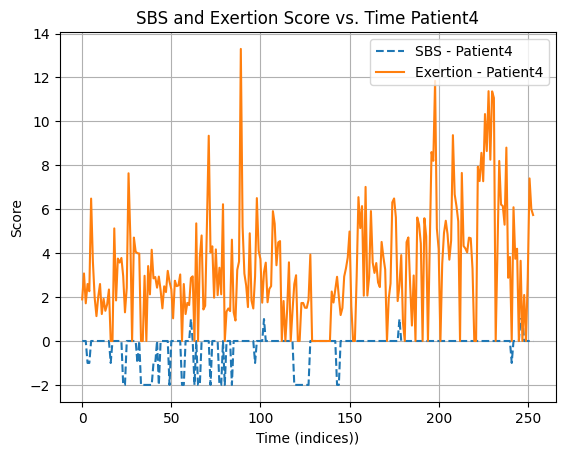

Patient4 SBS Score : 0, Median Exertion Score: 3.19e+00
Patient4 SBS Score : -1, Median Exertion Score: 2.72e+00
Patient4 SBS Score : -2, Median Exertion Score: 2.07e+00
Patient4 SBS Score : 1, Median Exertion Score: 2.87e+00
C:\Users\sidha\OneDrive\Sid_stuff\PROJECTS\PedAccel\data_analysis\Vitals_accel_analysis\PatientData\Patient9
Processing patient: Patient9
dict_keys(['__header__', '__version__', '__globals__', 'x_mag', 'heart_rate', 'SpO2', 'respiratory_rate', 'blood_pressure_systolic', 'blood_pressure_mean', 'blood_pressure_diastolic', 'sbs', 'start_time', 'PRNs'])


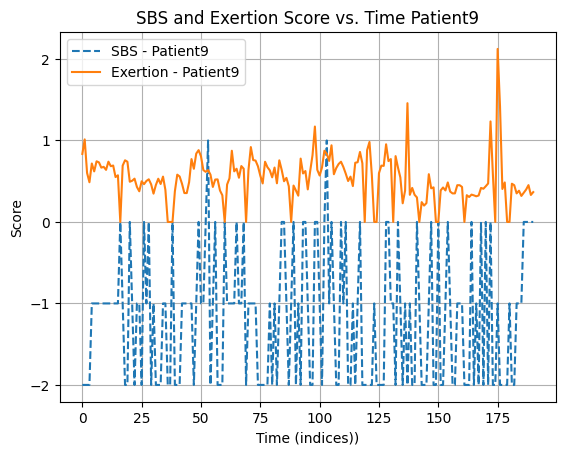

Patient9 SBS Score : -2, Median Exertion Score: 4.85e-01
Patient9 SBS Score : -1, Median Exertion Score: 5.51e-01
Patient9 SBS Score : 0, Median Exertion Score: 5.20e-01
Patient9 SBS Score : 1, Median Exertion Score: 7.37e-01


: 

In [ ]:
from tsfel import auc, calc_std, abs_energy, distance, rms

def calc_Exertion(accel_data, hr_data, resp_signal):
    auc_accel =  auc(accel_data, 100)
    hr_std = calc_std(hr_data)
    return (10**-12)*abs_energy(hr_data)*abs_energy(resp_signal)
    
#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    print(patient_dir)
    if os.path.isdir(patient_dir):
        print("Processing patient:", patient)
        #Vitals Data
        vitals_file_path = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_Retro.mat')
        if not os.path.isfile(vitals_file_path):
            continue
        vitals_data = loadmat(vitals_file_path)
        print(vitals_data.keys())
        hr = vitals_data["heart_rate"]
        resp = vitals_data["respiratory_rate"]
        # time = vitals_data['start_time'].flatten()
        sbs = vitals_data['sbs'].flatten()
        x_mag = vitals_data["x_mag"]

        # Remove all white spaces from each string
        exertion = []
        times = []
        SBS = [] #Need retrospective ecg data to use PRN info
        sbs_exertion_dict = {}
        resp_scores = []
        for i in range(len(sbs) - 1):
            try:
                sbs_score = int(sbs[i])
                # if sbs_score != 0:
                accel_signal = x_mag[i]
                accel_signal = Actigraph_Metrics.VecMag_MAD(accel_signal, window=100)
                hr_signal = hr[i]
                resp_signal = resp[i]
                exertion_score = calc_Exertion((accel_signal), hr_signal, resp_signal)
                exertion.append(exertion_score)
                SBS.append(sbs_score)
                times.append(i)
                if sbs_score not in sbs_exertion_dict:
                    sbs_exertion_dict[sbs_score] = []
                sbs_exertion_dict[sbs_score].append(exertion_score)
            except:
                continue
                        # Plotting

        plt.plot(times, SBS, label=f"SBS - {patient}", linestyle="--")
        plt.plot(times, exertion, label=f"Exertion - {patient}")

        plt.xlabel("Time (indices))")
        plt.ylabel("Score")
        plt.title(f"SBS and Exertion Score vs. Time {patient}")
        plt.legend()
        plt.grid()
        plt.show()
        # Calculate and print the average exertion score for each SBS score
        for sbs_score, exertion_scores in sbs_exertion_dict.items():
            median_exertion = np.median(exertion_scores)
            average_exertion = np.mean(exertion_scores)
            print(f"{patient} SBS Score : {sbs_score}, Median Exertion Score: {median_exertion:.2e}")


#Too much weight on accelerometry blows up SBS -2 because patient is moved

Processing patient: Patient11
Loaded vitals data for Patient11: dict_keys(['__header__', '__version__', '__globals__', 'x_mag', 'heart_rate', 'SpO2', 'respiratory_rate', 'blood_pressure_systolic', 'blood_pressure_mean', 'blood_pressure_diastolic', 'sbs', 'start_time', 'PRNs', 'Default'])
Patient11 SBS Score: -2, Median Exertion Score: 8.19e-01, Average Exertion Score: 1.72e+00
Patient11 SBS Score: 0, Median Exertion Score: 1.57e+00, Average Exertion Score: 2.42e+00
Patient11 SBS Score: 1, Median Exertion Score: 9.39e+00, Average Exertion Score: 9.39e+00
Patient11 SBS Score: -1, Median Exertion Score: 1.23e+01, Average Exertion Score: 1.23e+01
Extracted columns 'SBS' and 'Time_uniform' for Patient11
Loaded nurse SBS data for Patient11:    SBS           Time_uniform
0   -1  1/30/2024 08:00:00 PM
1   -1  1/31/2024 12:00:00 AM
2    1  1/31/2024 01:40:00 AM
3   -1  1/31/2024 04:00:00 AM
4    0  1/31/2024 08:00:00 AM
Loaded nurse SBS timestamps for Patient11: 0    1/30/2024 08:00:00 PM
1    

C:\Users\sidha\AppData\Local\Temp\ipykernel_35580\4271965718.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nurse_sbs['Time_uniform'] = pd.to_datetime(nurse_sbs['Time_uniform'], format='%m/%d/%Y %I:%M:%S %p')
C:\Users\sidha\AppData\Local\Temp\ipykernel_35580\4271965718.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='PRN')


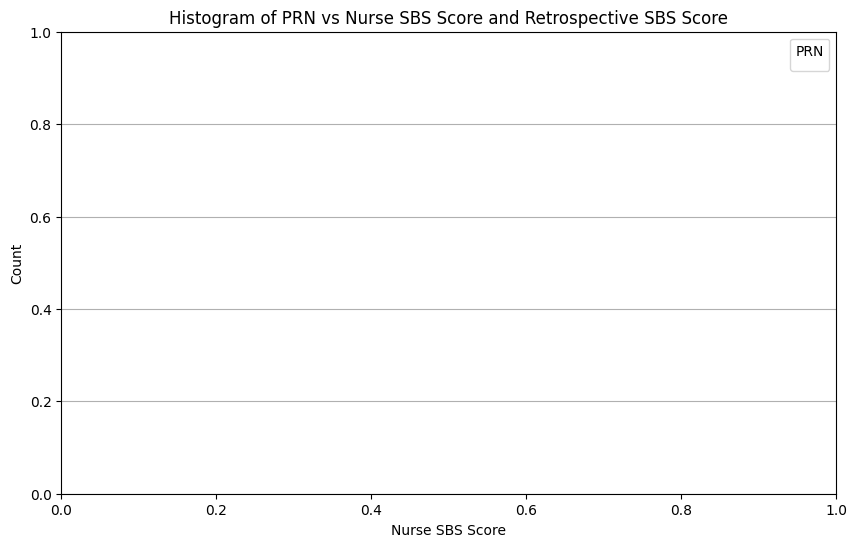

Extracted columns 'SBS' and 'Time_uniform' for Patient11
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
Name: Time_uniform, dtype: bool
Processing patient: Patient4
Loaded vitals data for Patient4: dict_keys(['__header__', '__version__', '__globals__', 'x_mag', 'heart_rate', 'SpO2', 'respiratory_rate', 'blood_pressure_systolic', 'blood_pressure_mean', 'blood_pressure_diastolic', 'sbs', 'start_time', 'PRNs', 'Default'])


KeyboardInterrupt: 

In [ ]:
# Iterate through each patient directory
for patient in os.listdir(data_dir):
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        print(f"Processing patient: {patient}")

        # Load Vitals Data
        vitals_file_path = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_{Tag}.mat')
        if not os.path.isfile(vitals_file_path):
            print(f"Vitals file not found for {patient}")
            continue
        vitals_data = loadmat(vitals_file_path)
        print(f"Loaded vitals data for {patient}: {vitals_data.keys()}")

        hr = vitals_data["heart_rate"]
        resp = vitals_data["respiratory_rate"]
        sbs = vitals_data['sbs'].flatten()
        start_time = vitals_data['start_time'].flatten()
        PRNs = vitals_data['PRNs'].flatten()

        # Load Nurse SBS Scores
        nurse_sbs_file_path = os.path.join(patient_dir, f'{patient}_SBS_Scores.xlsx')
        if os.path.isfile(nurse_sbs_file_path):
            nurse_sbs_data = pd.read_excel(nurse_sbs_file_path)
            if 'SBS' in nurse_sbs_data.columns and 'Time_uniform' in nurse_sbs_data.columns:
                nurse_sbs = nurse_sbs_data[['SBS', 'Time_uniform']]
                print(f"Extracted columns 'SBS' and 'Time_uniform' for {patient}")
            else:
                print(f"Columns 'SBS' and 'Time_uniform' not found in {nurse_sbs_file_path}")

            
            print(f"Loaded nurse SBS data for {patient}: {nurse_sbs.head()}")
            print(f"Loaded nurse SBS timestamps for {patient}: {nurse_sbs['Time_uniform'].head()}")
            
            # Filter nurse SBS scores that share a timestamp with vitals data
            # Convert 'Time_uniform' to datetime for compatibility
            nurse_sbs['Time_uniform'] = pd.to_datetime(nurse_sbs['Time_uniform'], format='%m/%d/%Y %I:%M:%S %p')

            # Convert 'start_time' in vitals_data to datetime for compatibility
            vitals_data['start_time'] = pd.to_datetime(vitals_data['start_time'])

            # Filter nurse SBS scores that share a timestamp with vitals data
            shared_timestamps = nurse_sbs['Time_uniform'].isin(vitals_data['start_time'])
            print(shared_timestamps)
            filtered_nurse_sbs = nurse_sbs[shared_timestamps]

            # Create a DataFrame with the required columns
            combined_df = pd.DataFrame({
                'Timestamp': filtered_nurse_sbs['Time_uniform'],
                'Nurse_SBS': filtered_nurse_sbs['SBS'],
                'Vitals_SBS': sbs[:len(filtered_nurse_sbs)],  # Match lengths
                'PRN': vitals_data['PRNs'][:len(filtered_nurse_sbs)]  # Match lengths
            })

            print(f"Combined DataFrame for {patient}:")
            print(combined_df)

            # Count occurrences of PRN values for each Nurse SBS and Retrospective SBS
            prn_counts = combined_df.groupby(['PRN', 'Nurse_SBS', 'Vitals_SBS']).size().reset_index(name='Count')

            # Plot histogram
            fig, ax = plt.subplots(figsize=(10, 6))
            for prn in prn_counts['PRN'].unique():
                subset = prn_counts[prn_counts['PRN'] == prn]
                ax.bar(subset['Nurse_SBS'], subset['Count'], label=f'PRN: {prn}', alpha=0.7)

            ax.set_xlabel('Nurse SBS Score')
            ax.set_ylabel('Count')
            ax.set_title('Histogram of PRN vs Nurse SBS Score and Retrospective SBS Score')
            ax.legend(title='PRN')
            plt.grid(axis='y')
            plt.show()
        if os.path.isfile(nurse_sbs_file_path):
            nurse_sbs_data = pd.read_excel(nurse_sbs_file_path)
            if 'SBS' in nurse_sbs_data.columns and 'Time_uniform' in nurse_sbs_data.columns:
                nurse_sbs = nurse_sbs_data[['SBS', 'Time_uniform']]
                print(f"Extracted columns 'SBS' and 'Time_uniform' for {patient}")
            else:
                print(f"Columns 'SBS' and 'Time_uniform' not found in {nurse_sbs_file_path}")
            
            # Filter nurse SBS scores that share a timestamp with vitals data
            shared_timestamps = nurse_sbs['Time_uniform'].isin(vitals_data['start_time'])
            print(shared_timestamps)
            filtered_nurse_sbs = nurse_sbs[shared_timestamps]